In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df_credit = pd.read_csv("/content/drive/MyDrive/AnálisisdeDatosaGranEscala/creditcard.csv")

X = df_credit.drop(columns=['Class','Time'])
y = df_credit['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_sample, _, y_sample, _ = train_test_split(X_scaled, y, train_size=15000, stratify=y, random_state=42)

In [ ]:
y.value_counts()

,count
Class,
0,284315
1,492


In [ ]:
print("Número de dimensiones:", X.shape[1])

Número de dimensiones: 29


## **Block Nested-Loop Join Algorithm**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def block_nested_loop_knn(X, k=5, n_outliers=492):
    """
    Algoritmo Block Nested-Loop KNN para detección de outliers.
    Usa distancia euclidiana al cuadrado como en el paper original.
    """
    n = X.shape[0]
    dk_values = np.zeros(n)

    # distancias al k-ésimo vecino para cada punto
    for i in range(n):
        dists = np.sum((X - X[i]) ** 2, axis=1)
        dists[i] = np.inf  # Ignorar la distancia a sí mismo
        dk_values[i] = np.partition(dists, k - 1)[k - 1]

    # obtener índices de los top-n puntos con mayor Dk
    outlier_indices = np.argsort(dk_values)[-n_outliers:]

    # predicciones: 1 = outlier, 0 = normal
    y_pred = np.zeros(n, dtype=int)
    y_pred[outlier_indices] = 1

    return y_pred, dk_values

print(f"Muestra seleccionada con {X_sample.shape[0]} registros")
y_pred_block_sample, scores_block_sample = block_nested_loop_knn(X_sample, k=5, n_outliers=sum(y_sample))

conf_matrix_sample = confusion_matrix(y_sample, y_pred_block_sample)
report_sample = classification_report(y_sample, y_pred_block_sample, output_dict=True)
auc_sample = roc_auc_score(y_sample, scores_block_sample)

print("Matriz de Confusión:\n", conf_matrix_sample)
print("\nReporte de Clasificación:\n", classification_report(y_sample, y_pred_block_sample))
print(f"\nAUC ROC: {auc_sample:.4f}")

Muestra seleccionada con 15000 registros
Matriz de Confusión:
 [[14955    19]
 [   19     7]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14974
           1       0.27      0.27      0.27        26

    accuracy                           1.00     15000
   macro avg       0.63      0.63      0.63     15000
weighted avg       1.00      1.00      1.00     15000


AUC ROC: 0.9538


In [ ]:
import time

start = time.time()
y_pred_block, dk_block = block_nested_loop_knn(X_sample, k=5, n_outliers=sum(y_sample))
end = time.time()

print(f"Tiempo de ejecución (Block Nested Loop): {end - start:.4f} segundos")

Tiempo de ejecución (Block Nested Loop): 24.2611 segundos


## **Index-Based Algorithm**

In [ ]:
pip install Rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
try:
    from rtree import index
    from sklearn.metrics.pairwise import euclidean_distances

    def rtree_knn_outliers(X, k=5, n_outliers=492):
        n, d = X.shape
        p = index.Property()
        p.dimension = d
        rtree_idx = index.Index(properties=p)

        # insertar cada punto como un rectángulo mínimo (x, x)
        for i, point in enumerate(X):
            coords = tuple(point) * 2
            rtree_idx.insert(i, coords)

        start = time.time()

        dk_values = np.zeros(n)
        for i, point in enumerate(X):
            # bounding box puntual para búsqueda
            coords = tuple(point) * 2
            neighbors = list(rtree_idx.nearest(coords, k + 1))
            neighbors = [n for n in neighbors if n != i][:k]  # remover el mismo punto

            # calcular distancias reales
            dists = euclidean_distances([point], X[neighbors])[0]
            dk_values[i] = np.max(dists) ** 2  # distancia al vecino más lejano

        end = time.time()
        elapsed = end - start

        outlier_indices = np.argsort(dk_values)[-n_outliers:]
        y_pred = np.zeros(n, dtype=int)
        y_pred[outlier_indices] = 1

        return y_pred, dk_values, elapsed

    y_pred_rtree, scores_rtree, tiempo_rtree = rtree_knn_outliers(X_sample, k=5, n_outliers=sum(y_sample))

    conf_matrix_rtree = confusion_matrix(y_sample, y_pred_rtree)
    report_rtree = classification_report(y_sample, y_pred_rtree, output_dict=True)
    auc_rtree = roc_auc_score(y_sample, scores_rtree)

    resultado_rtree = (conf_matrix_rtree, report_rtree, auc_rtree)
    print(f"Tiempo de búsqueda (solo con CPU): {tiempo_rtree:.4f} segundos")
    print("Matriz de Confusión:\n", conf_matrix_rtree)
    print("\nReporte de Clasificación:\n", classification_report(y_sample, y_pred_rtree))
    print(f"\nAUC ROC: {auc_rtree:.4f}")

except Exception as e:
    print(f"Error: {e}")


Tiempo de búsqueda (solo CPU): 217.6633 segundos
Matriz de Confusión:
 [[14955    19]
 [   19     7]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14974
           1       0.27      0.27      0.27        26

    accuracy                           1.00     15000
   macro avg       0.63      0.63      0.63     15000
weighted avg       1.00      1.00      1.00     15000


AUC ROC: 0.9538


## **Partition-Based Algorithm**

In [ ]:
from sklearn.cluster import Birch

def partition_based_knn(X, y_true, k=5, n_outliers=492, n_clusters=10):
    # 1. agrupa datos en clusters usando BIRCH
    birch_model = Birch(n_clusters=n_clusters)
    labels = birch_model.fit_predict(X)

    dk_values = np.zeros(len(X))
    candidate_indices = []

    # 2. evalúa cada dispersión por cada cluster
    for cluster_id in np.unique(labels):
        cluster_points_idx = np.where(labels == cluster_id)[0]
        cluster_points = X[cluster_points_idx]

        if len(cluster_points) <= k:
            continue  # no se puede calcular Dk con pocos puntos

        # calcular Dk local
        local_dk = np.zeros(len(cluster_points))
        for i in range(len(cluster_points)):
            dists = np.sum((cluster_points - cluster_points[i]) ** 2, axis=1)
            dists[i] = np.inf
            local_dk[i] = np.partition(dists, k - 1)[k - 1]

        # guarda los puntajes de distancia en las posiciones correctas
        dk_values[cluster_points_idx] = local_dk
        candidate_indices.extend(cluster_points_idx)

    # 3. escoger top-n outliers
    candidate_indices = np.array(candidate_indices)
    candidate_scores = dk_values[candidate_indices]
    top_n_indices = candidate_indices[np.argsort(candidate_scores)[-n_outliers:]]

    # 4. vector de predicciones
    y_pred = np.zeros(len(X), dtype=int)
    y_pred[top_n_indices] = 1

    return y_pred, dk_values

y_pred_partition, scores_partition = partition_based_knn(X_sample, y_sample, k=5, n_outliers=sum(y_sample), n_clusters=10)

print("Matriz de Confusión:\n", confusion_matrix(y_sample, y_pred_partition))
print("\nReporte de Clasificación:\n", classification_report(y_sample, y_pred_partition))
print("AUC:", roc_auc_score(y_sample, scores_partition))

Matriz de Confusión:
 [[14955    19]
 [   19     7]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14974
           1       0.27      0.27      0.27        26

    accuracy                           1.00     15000
   macro avg       0.63      0.63      0.63     15000
weighted avg       1.00      1.00      1.00     15000

AUC: 0.952983890024761


In [ ]:
start = time.time()

y_pred_partition, scores_partition = partition_based_knn(
    X_sample, y_sample, k=5, n_outliers=sum(y_sample), n_clusters=10
)
end = time.time()
print("Tiempo de ejecución: {:.4f} segundos".format(end - start))

Tiempo de ejecución: 29.3087 segundos


## **Visualización**

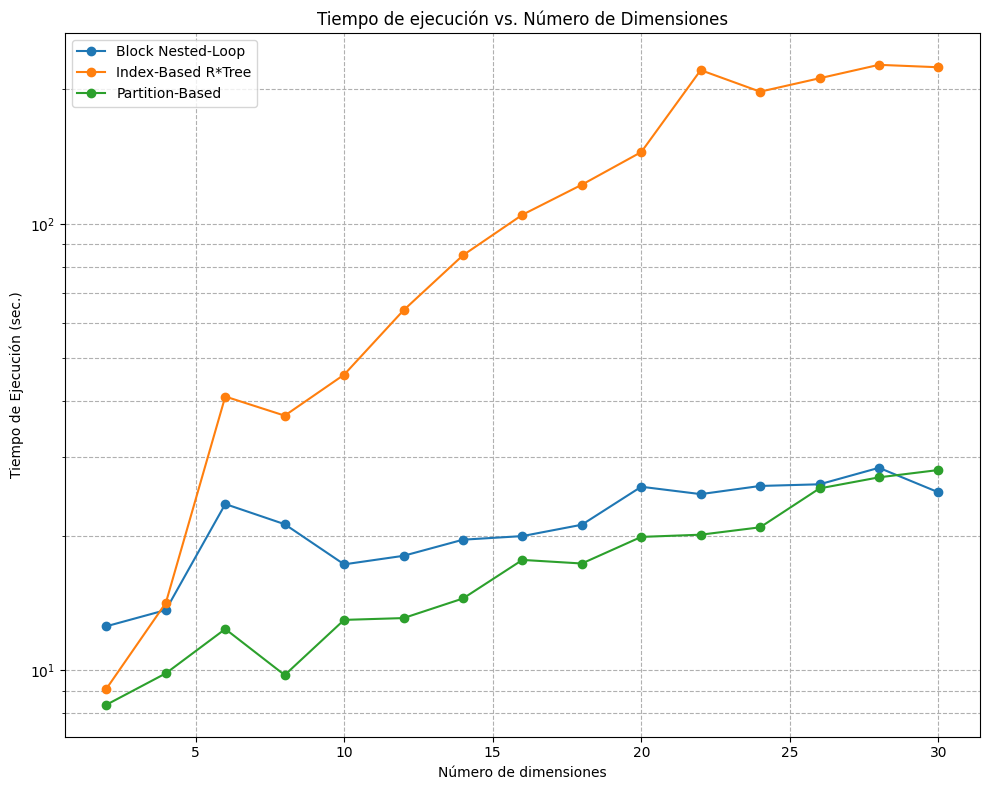

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

dims = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
results = {
    'Block Nested-Loop': [],
    'Index-Based R*Tree': [],
    'Partition-Based': []
}
for d in dims:
    X_d = X_sample[:, :d]

    # Block Nested-Loop
    start = time.time()
    _ = block_nested_loop_knn(X_d, k=5, n_outliers=sum(y_sample))
    results['Block Nested-Loop'].append(time.time() - start)

    # Index-Based
    start = time.time()
    _ = rtree_knn_outliers(X_d, k=5, n_outliers=sum(y_sample))
    results['Index-Based R*Tree'].append(time.time() - start)

    # Partition-Based
    start = time.time()
    _ = partition_based_knn(X_d, y_sample, k=5, n_outliers=sum(y_sample), n_clusters=10)
    results['Partition-Based'].append(time.time() - start)

plt.figure(figsize=(10, 8))
for algo, times in results.items():
    plt.plot(dims, times, marker='o', label=algo)

plt.yscale('log')
plt.xlabel('Número de dimensiones')
plt.ylabel('Tiempo de Ejecución (sec.)')
plt.title('Tiempo de ejecución vs. Número de Dimensiones')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()
